In [26]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.linear_model import ElasticNet

In [2]:
#data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\houses_to_buy_nbg_preprocessed.xlsx')
data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\data\flats_to_rent_wue_preprocessed_0407.xlsx')

In [3]:
data.replace('""', np.nan, inplace=True)

In [4]:
data['DistributionType'].unique()

array(['RENT'], dtype=object)

In [148]:
data = data[data['DistributionType']=='BUY']

In [149]:
data = data[data['EstateType']=='HOUSE']

In [5]:
data

,Unnamed: 0,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,475.0,50.0,2.0,NaN,97209,APARTMENT,RENT,0,0,...,0,0,0,0,1,1,0,0,0,0
2,2,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,...,0,0,0,0,1,0,1,0,0,1
3,3,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,560.0,50.0,2.0,NaN,97076,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,1
172,172,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,0
173,173,2175.0,150.0,5.5,NaN,97070,APARTMENT,RENT,1,0,...,0,0,0,0,1,0,0,0,0,1
174,174,1185.0,85.0,3.0,1920.0,97078,APARTMENT,RENT,0,0,...,0,0,0,0,1,0,0,0,0,1


In [6]:
data['ConstructionYear'].isnull().sum()
print(data.isnull().sum())

Unnamed: 0                  0
Object_price                0
LivingSpace                 0
Rooms                       0
ConstructionYear           38
                           ..
wasch_trockenraum           0
wg_geeignet                 0
wintergarten                0
wohnberechtigungsschein     0
zentralheizung              0
Length: 87, dtype: int64


In [7]:
data.dropna(inplace=True)
data["LivingSpace"] = pd.to_numeric(data["LivingSpace"], errors="coerce")
data["Rooms"] = pd.to_numeric(data["Rooms"], errors="coerce")
data.dropna(subset=['ConstructionYear'], inplace=True)
data.dropna(subset=['Object_price'], inplace=True)
data.dropna(subset=['Rooms'], inplace=True)
data.dropna(subset=['LivingSpace'], inplace=True)
#data.drop('ContactData', axis=1, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
#data.drop('Object_currency', axis=1, inplace=True)
#data.drop('Url', axis=1, inplace=True)
#data.drop('EstateType', axis=1, inplace=True)
#data.drop('DistributionType', axis=1, inplace=True)
data['ZipCode']= data['ZipCode'].astype(str)
data['LivingSpace']= data['LivingSpace'].astype(float)
data = data.reindex()

In [8]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,altbau_(bis_1945),...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,0,...,1,0,0,0,1,0,0,0,0,1
6,1250.0,115.0,3.5,2019.0,97246,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2880.0,195.0,6.0,2023.0,97218,APARTMENT,RENT,0,0,0,...,0,1,0,0,1,0,0,0,0,0
169,1100.0,103.0,4.0,1984.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,0
170,715.0,82.2,3.0,1900.0,97299,APARTMENT,RENT,0,0,1,...,0,0,0,0,1,0,0,0,0,0
172,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(data.isnull().sum())

Object_price               0
LivingSpace                0
Rooms                      0
ConstructionYear           0
ZipCode                    0
                          ..
wasch_trockenraum          0
wg_geeignet                0
wintergarten               0
wohnberechtigungsschein    0
zentralheizung             0
Length: 86, dtype: int64


In [10]:
data = data.reset_index(drop=True)

In [11]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,altbau_(bis_1945),...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,1250.0,115.0,3.5,2019.0,97246,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2880.0,195.0,6.0,2023.0,97218,APARTMENT,RENT,0,0,0,...,0,1,0,0,1,0,0,0,0,0
134,1100.0,103.0,4.0,1984.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,0
135,715.0,82.2,3.0,1900.0,97299,APARTMENT,RENT,0,0,1,...,0,0,0,0,1,0,0,0,0,0
136,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\mbauer2\AppData\Local\Temp\ipykernel_14968\1150594620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="RdBu")


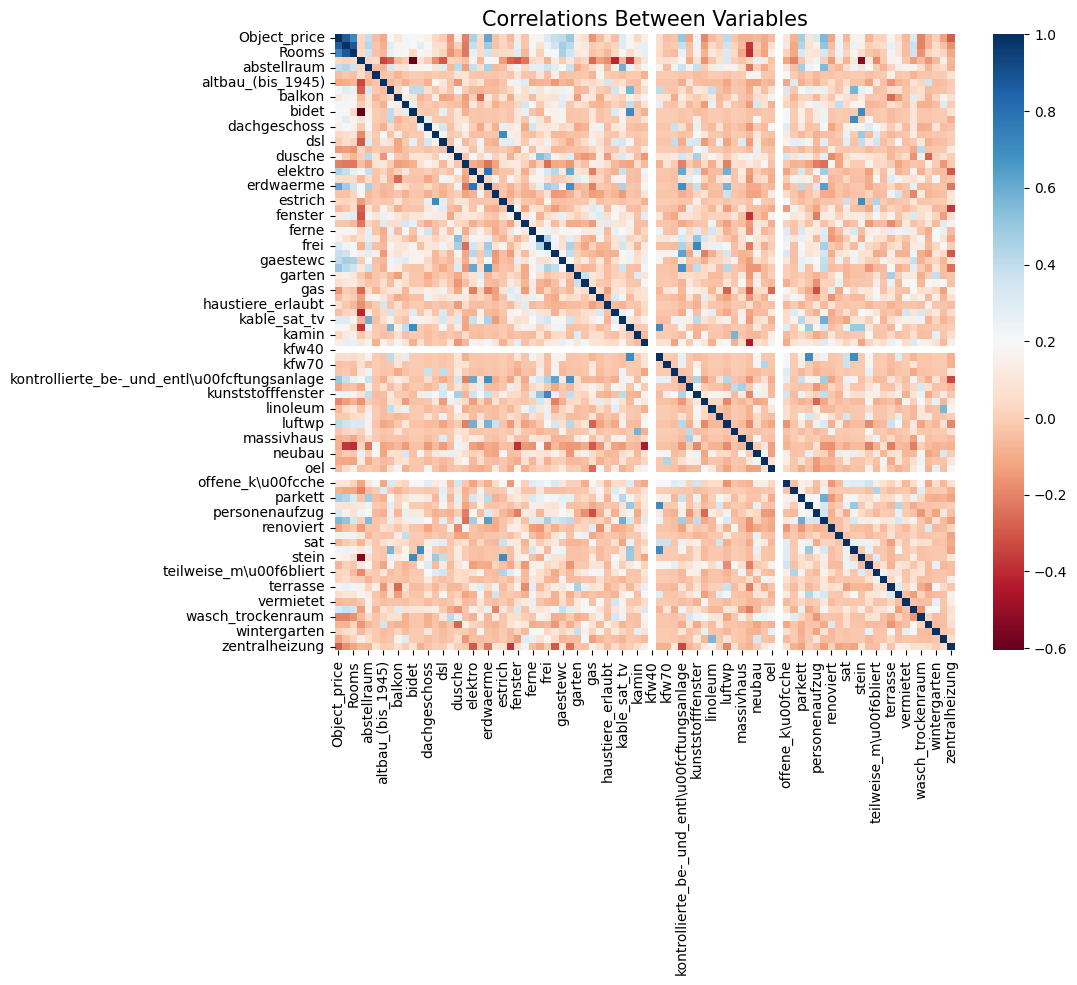

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [13]:
important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)

C:\Users\mbauer2\AppData\Local\Temp\ipykernel_14968\847568539.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)


In [14]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
cat_cols

['ZipCode', 'EstateType', 'DistributionType']

In [15]:
important_cols = important_num_cols + cat_cols

data = data[important_cols]

In [16]:
important_num_cols

['Object_price',
 'LivingSpace',
 'Rooms',
 'abstellraum',
 'bad/wc_getrennt',
 'barriefrei',
 'bidet',
 'einbauk\\u00fcche',
 'elektro',
 'erdwaerme',
 'frei',
 'fu\\u00dfbodenheizung',
 'gaestewc',
 'garage',
 'kable_sat_tv',
 'kontrollierte_be-_und_entl\\u00fcftungsanlage',
 'kunststofffenster',
 'luftwp',
 'parkett',
 'personenaufzug',
 'reinigung',
 'rollstuhlgerecht',
 'wanne',
 'wasch_trockenraum',
 'zentralheizung']

In [40]:
y = data['Object_price']
X = data.drop('Object_price', axis=1)
print(y.head())
print(X.head())
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
X = pd.get_dummies(X, columns=cat_cols)

0     995.0
1     750.0
2     580.0
3     780.0
4    1250.0
Name: Object_price, dtype: float64
   LivingSpace  Rooms  abstellraum  bad/wc_getrennt  barriefrei  bidet  \
0         50.0    1.5            0                0           0      0   
1         70.0    2.0            0                0           0      0   
2         74.0    3.0            0                0           0      0   
3         86.0    3.0            0                0           0      0   
4        115.0    3.5            0                0           1      0   

   einbauk\u00fcche  elektro  erdwaerme  frei  ...  parkett  personenaufzug  \
0                 1        0          0     0  ...        0               0   
1                 1        0          0     0  ...        0               0   
2                 1        1          0     0  ...        0               0   
3                 1        0          0     0  ...        0               0   
4                 0        0          0     0  ...        0      

In [45]:
X

,LivingSpace,Rooms,abstellraum,bad/wc_getrennt,barriefrei,bidet,einbauk\u00fcche,elektro,erdwaerme,frei,...,ZipCode_97246,ZipCode_97249,ZipCode_97250,ZipCode_97261,ZipCode_97270,ZipCode_97288,ZipCode_97297,ZipCode_97299,EstateType_APARTMENT,DistributionType_RENT
0,50.0,1.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,70.0,2.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,74.0,3.0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
3,86.0,3.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,115.0,3.5,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,195.0,6.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
134,103.0,4.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
135,82.2,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
136,72.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [41]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

In [44]:

model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
model.fit(X=train_X, 
          y=train_y,
          eval_set=[(val_X, val_y)],  # Liste mit Validierungsdaten und Zielvariablen
          verbose=True
)
preds= model.predict(test_X)
score_House = mean_absolute_error(test_y, preds)

print("MAE House: {}".format(score_House))




[0]	validation_0-rmse:789.05448	validation_0-mae:689.82105
[1]	validation_0-rmse:573.56434	validation_0-mae:484.09524
[2]	validation_0-rmse:429.39471	validation_0-mae:339.46749
[3]	validation_0-rmse:327.95919	validation_0-mae:240.33495
[4]	validation_0-rmse:271.51062	validation_0-mae:173.21899
[5]	validation_0-rmse:263.05629	validation_0-mae:177.64294
[6]	validation_0-rmse:271.60454	validation_0-mae:183.17610
[7]	validation_0-rmse:288.47457	validation_0-mae:182.65352
[8]	validation_0-rmse:309.84957	validation_0-mae:189.41346
[9]	validation_0-rmse:330.46469	validation_0-mae:201.99247
[10]	validation_0-rmse:346.54070	validation_0-mae:211.82935


[11]	validation_0-rmse:349.93356	validation_0-mae:215.36463
[12]	validation_0-rmse:355.03683	validation_0-mae:220.38869
[13]	validation_0-rmse:357.20198	validation_0-mae:222.20600
[14]	validation_0-rmse:360.83612	validation_0-mae:229.00910
[15]	validation_0-rmse:363.40318	validation_0-mae:231.41579
[16]	validation_0-rmse:365.21245	validation_0-mae:234.95140
[17]	validation_0-rmse:367.49342	validation_0-mae:238.77713
[18]	validation_0-rmse:368.36703	validation_0-mae:239.50762
[19]	validation_0-rmse:369.88729	validation_0-mae:242.00631
[20]	validation_0-rmse:371.18077	validation_0-mae:242.34351
[21]	validation_0-rmse:371.43902	validation_0-mae:241.11728
[22]	validation_0-rmse:373.09386	validation_0-mae:242.60875
[23]	validation_0-rmse:374.47829	validation_0-mae:243.09106
[24]	validation_0-rmse:375.29741	validation_0-mae:243.96124
[25]	validation_0-rmse:376.18587	validation_0-mae:244.64366
[26]	validation_0-rmse:376.83772	validation_0-mae:245.68287
[27]	validation_0-rmse:377.91466	validat

[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's rmse: 420.738	valid_0's l1: 300.357
[2]	valid_0's rmse: 397.009	valid_0's l1: 286.3
[3]	valid_0's rmse: 378.49	valid_0's l1: 281.727
[4]	valid_0's rmse: 364.475	valid_0's l1: 277.612
[5]	valid_0's rmse: 353.844	valid_0's l1: 273.271
[6]	valid_0's rmse: 346.945	valid_0's l1: 270.415
[7]	valid_0's rmse: 342.232	valid_0's l1: 266.878
[8]	valid_0's rmse: 339.85	valid_0's l1: 269.687
[9]	valid_0's rmse: 335.568	valid_0's l1: 272.597
[10]	valid_0's rmse: 334.902	valid_0's l1: 274.369
[11]	valid_0's rmse: 333.052	valid_0's l1: 276.87
[12]	valid_0's rmse: 334.186	valid_0's l1: 280.022
[13]	valid_0's rmse: 334.175	valid_0's l1: 284.178
[14]	valid_0's rmse: 327.774	valid_0's l1: 282.316
[15]	valid_0's rmse: 329.814	valid_0's l1: 286.383
[16]	valid_0's rmse: 324.87	valid_0's l1: 284.732
[17]	valid_0's rmse: 326.346	valid_0's l1: 289.084
[18]	valid_0's

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

n_estimators = [10, 50, 100, 200, 300, 400, 500]
train_maes = []
valid_maes = []
for n in n_estimators:
    
    rf_model = RandomForestRegressor(n_estimators=n, random_state=0)
    rf_model.fit(train_X, train_y)

    
    preds_train_rf = rf_model.predict(train_X)
    preds_valid_rf = rf_model.predict(val_X)

    
    train_mae = mean_absolute_error(train_y, preds_train_rf)
    valid_mae = mean_absolute_error(val_y, preds_valid_rf)

    
    train_maes.append(train_mae)
    valid_maes.append(valid_mae)

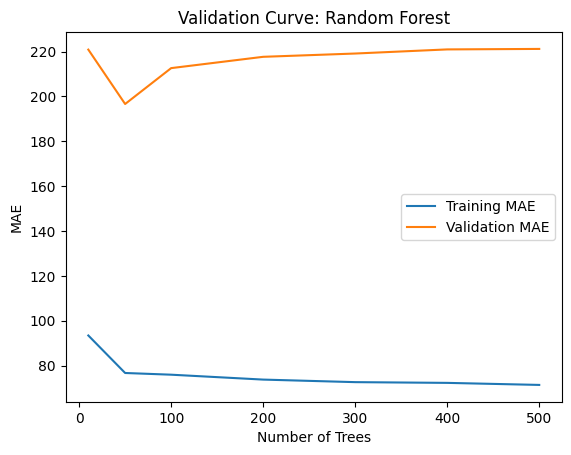

In [49]:
plt.plot(n_estimators, train_maes, label='Training MAE')
plt.plot(n_estimators, valid_maes, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
plt.legend()
plt.title('Validation Curve: Random Forest')
plt.show()

In [54]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
rf_model = RandomForestRegressor(n_estimators=50, random_state=0)
rf_model.fit(train_X, train_y)
preds_test_rf = rf_model.predict(test_X)
score = mean_absolute_error(test_y, preds_test_rf)
print("MAE: {}".format(score))

MAE: 146.7308142857142


In [51]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
elastic_net = ElasticNet(max_iter=30)
elastic_net.fit(train_X, train_y)
test_preds = elastic_net.predict(test_X)
test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)



MAE auf Testdaten: 183.30259829412995
